<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/screening_of_organic_materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 有機材料において所望の部分構造有無によるスクリーニングを行う

### 右上の「接続」をクリックし、ランタイムに接続

## ライブラリをインストール

In [1]:
! pip install py3Dmol==2.4.0
! pip install rdkit==2024.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 59.3 MB/s eta 0:00:00


### 「ランタイム」タブから「セッションを再起動する」を選択し、「はい」をクリック

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、PubChem_compound_smarts_O=C(O).csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
import gc
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import py3Dmol
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Descriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

## データを読み込み、データフレームに格納

In [4]:
df = pd.read_csv(INPUT_FILE_PATH + "PubChem_compound_smarts_O=C(O).csv")
df

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,4109,Methomyl,16752-77-5|Lannate|Mesomile|Methomyl|Methyl N-...,162.21,C5H10N2O2S,76.0,147.0,0.6,10,1,...,498,2D+3D,Methomyl,Agrochemical Information|Biological Test Resul...,16,425000|977599|977602|1081777|1081778|1081779|1...,20050325,3B Scientific (Wuhan) Corp|ABI Chem|Acadechem|...,Chemical Vendors|Curation Efforts|Governmental...,D004791 - Enzyme Inhibitors|D010575 - Pesticid...
1,6249,Ampicillin,69-53-4|Ampicillin|Aminobenzylpenicillin|Ampic...,349.40,C16H19N3O4S,138.0,562.0,-1.1,24,3,...,69138,2D+3D,Ampicillin,Biological Test Results|Chemical and Physical ...,16,357|361|364|368|371|373|374|375|411|422|425|42...,20050624,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C254 - Anti-Infective Agent > C258 - Antibioti...
2,6277,Cobalt(II) acetate,Cobalt acetate|Cobalt(II) acetate|71-48-7|Coba...,177.02,C4H6CoO4,80.3,25.5,NaN,9,0,...,20991,2D,NaN,Biological Test Results|Chemical and Physical ...,14,651631|651632|651633|651634|720516|720552|7206...,20050719,3B Scientific (Wuhan) Corp|3WAY PHARM INC|ABI ...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,10112,Calcium Carbonate,Aragonite|CALCIUM CARBONATE|471-34-1|Limestone...,100.09,CCaO3,63.2,18.8,NaN,5,0,...,119575,2D,Calcium Carbonate,Agrochemical Information|Biological Test Resul...,16,1259407|1259409,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,A - Alimentary tract and metabolism > A02 - Dr...
4,36314,Paclitaxel,33069-62-4|P88XT4IS4D|Paclitaxel|Taxol|Taxol A...,853.90,C47H51NO14,221.0,1790.0,2.5,62,4,...,64277,2D,NaN,Biological Test Results|Chemical and Physical ...,15,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C274 - Antineoplastic Agent > C186664 - Cytoto...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60148448,Pharmakon1600-01503834,GADOTERIDOL|120066-54-8|Pharmakon1600-01503834...,559.70,C17H30GdN4O7+,134.0,494.0,NaN,29,1,...,0,2D,NaN,Biological Test Results|Chemical and Physical ...,13,1794731|1794732|1794733|1794735|1794736|179473...,20120831,DTP/NCI|ToxPlanet,Governmental Organizations|Legacy Depositors|S...,V - Various > V08 - Contrast media > V08C - Ma...
996,133562742,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",oleandomycin,687.90,C35H61NO12,166.0,1090.0,2.6,48,3,...,0,2D,Oleandomycin,Chemical and Physical Properties|Classificatio...,13,NaN,20180525,Ambinter|Wikidata,Chemical Vendors|Curation Efforts,D000890 - Anti-Infective Agents > D000900 - An...
997,134755071,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",vincristine,825.00,C46H56N4O10,171.0,1750.0,2.8,60,3,...,0,2D,NaN,Biological Test Results|Chemical and Physical ...,13,1508598,20180905,Cheminformatics Friedrich-Schiller-University ...,Legacy Depositors|Research and Development,L - Antineoplastic and immunomodulating agents...
998,136601293,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",rifampin|Rifampicin|CHEMBL1523493|PD087064,822.90,C43H58N4O12,220.0,1620.0,4.9,59,6,...,2,2D,Rifampin,Biological Test Results|Chemical and Physical ...,13,1671498,20190124,ChEMBL|Google Patents|Human Metabolome Databas...,Curation Efforts|Research and Development,D000890 - Anti-Infective Agents > D000900 - An...


In [5]:
# dfから'cmpdname'と'canonicalsmiles'のみを抽出
df = df[["cmpdname", "canonicalsmiles"]]
df

,cmpdname,canonicalsmiles
0,Methomyl,CC(=NOC(=O)NC)SC
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2]
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2]
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...
...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...


## SMILES から ROMol オブジェクトを生成

,cmpdname,canonicalsmiles,ROMol
0,Methomyl,CC(=NOC(=O)NC)SC,
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2],
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2],
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,
...,...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...,
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...,
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...,

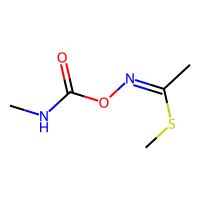
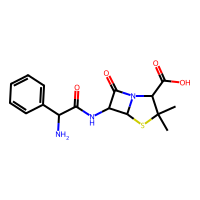
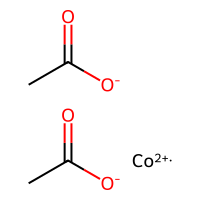
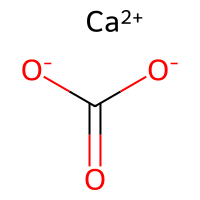
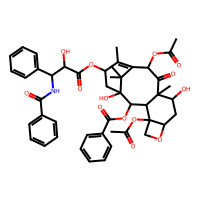
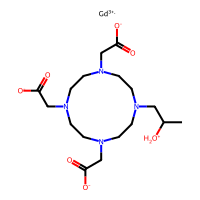
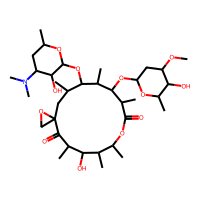
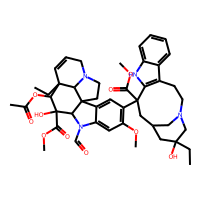
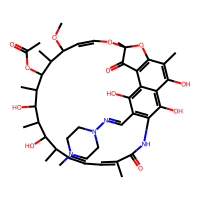
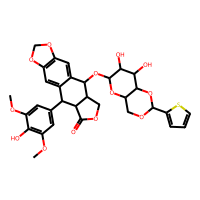

In [6]:
PandasTools.AddMoleculeColumnToFrame(df, "canonicalsmiles")
df

## ベンゾイル基のRoMolオブジェクトを生成（所望の部分構造有無のテーマに今回はベンゾイル基を使用）

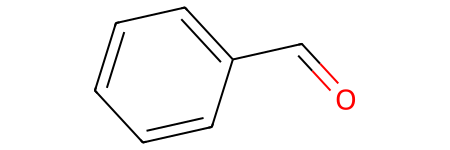

In [7]:
benzoyl_group = Chem.MolFromSmiles("c1ccccc1C=O")
benzoyl_group

## データ内でベンゾイル基を持つものをスクリーニング

In [8]:
# dfのROMol列をmolsというリストに格納
mols = df["ROMol"].tolist()

In [9]:
# benzoyl_group_compoundsを含むものをスクリーニング
benzoyl_group_compounds = []
not_benzoyl_group_compounds = []
for mol in mols:
    if mol.HasSubstructMatch(benzoyl_group):
        benzoyl_group_compounds.append(mol)
    else:
        not_benzoyl_group_compounds.append(mol)

In [10]:
# benzoyl_group_compoundsとnot_benzoyl_group_compoundsの数をカウント
print(f"Number of benzoyl group compounds: {len(benzoyl_group_compounds)}")
print(f"Number of not benzoyl group compounds: {len(not_benzoyl_group_compounds)}")

Number of benzoyl group compounds: 136
Number of not benzoyl group compounds: 864


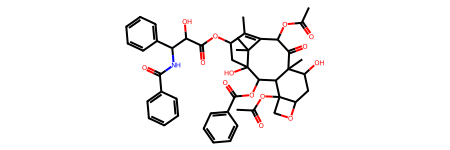

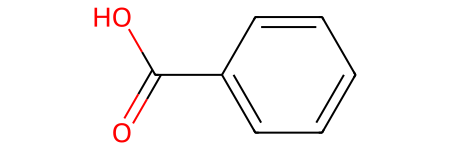

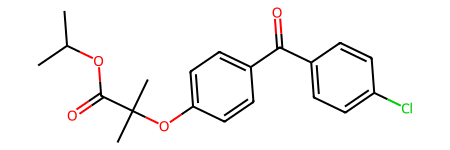

In [11]:
# benzoyl_group_compoundsの化合物を描画
for mol in benzoyl_group_compounds[0:3]:
    display(mol)

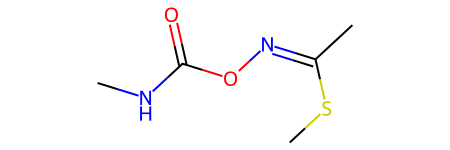

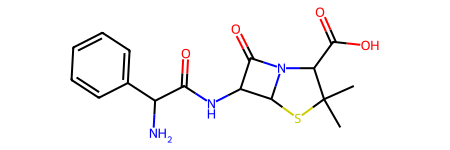

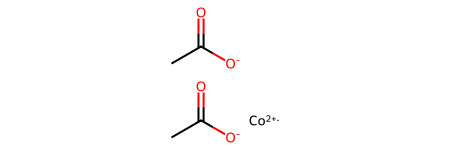

In [12]:
# not_benzoyl_group_compoundsの化合物を描画
for mol in not_benzoyl_group_compounds[0:3]:
    display(mol)

## 実行環境のライブラリverを保存

In [13]:
# Pythonのverを確認
!python3 -V

Python 3.11.12


In [14]:
!pip freeze > requirements_screening_of_organic.txt

In [15]:
from google.colab import files

files.download('requirements_screening_of_organic.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>